In [1]:
# Packages
%matplotlib inline
# General function:
import time
import numpy as np
from numba import jit
from numba import njit
from numba.typed import List
# Animation and plots:
import matplotlib.pyplot as plt
import matplotlib.artist as art
from matplotlib import cm
from IPython import display
#Possible Animation packages
import matplotlib.animation as animation

In [2]:
# Input parameters: Only Type Here

# Plate Initialization:
x_length = 75/1000;           # [mm]-->[m]
y_length = 75/1000;           # [mm]-->[m]
nx = 450;                     # number of grid points 
ny = 450;                     # number of grid points
#############################################################################
# Plate Properties: Sample Material: AISI Type 316L Stainless Steel

T0 = 280; 			          # Initial ambient temperature [K]
k = 15; 			          # conductivity coefficient [W/m/K]
cp = .5*1000; 			      # specific heat [J/g/c]-->[J/kg/K]
rho = 8*1000; 		          # density [g/cc]-->[kg/m^3]
Melt_Temp = 1670;             # Melting point of material [k]
Est_Max_Temp = 2600;          # Estimated Max Temperature [K] (Should never exceed 3500 [K]) 
                              # If White is seen on the Temperature Contour, Raise the Maximum Temperature
#############################################################################
# Laser Initialization:

q = 350; 			          # laser power [W]
Speed = 50/1000; 	          # laser speed x [mm/sec] --> [m/sec]
L_Rad = .6/1000;              # Radius of the laser beam [mm] --> [m]
down_time  = .5;              # time simulated added after laser is finished

Path_Type = 'Letter'           # Enter string as 'Letter', 'Point', or 'Both' for laser path

# Inputs for Letter Guided laser:
Letters = list(['H','E','L','L','O','newLine','I','I','N']); # Enter capital letters use newLine to start a new line
X_Offset = 'Left';            # start position: string 'Left','Center', or 'Right'
Y_Offset = 'Top';             # start position: string 'Top','Center', or 'Bottom'
Letter_Height = 12.5/1000;    # maximum height of letters [mm] --> [m]
Letter_Width = 7.5/1000;      # maximum width of letters [mm] --> [m] 
Letter_Space = 5/1000;        # Space between letters [mm] --> [m] 

# Inputs for Point guided laser:
HS_Path =[[.012,0],[.012,-.015],'stop',[.018,0],[.018,-0.015],'stop',[.005,-.02],[.01,-.025],[.02,-.025],[.025,-.02]];    # Heat Source Points [x,y], [m]
path_stops = 2;               # the number of stops used
#############################################################################
# Simulation Options:

Sample_rate = 200;               # amount of samples collected per second
Frame_rate = 20;                 # Frames seen per second

Sim_Type = 'Steps';              # Enter 'Steps' to see multiple frames of the simulation and 'Final' to see the final frame.
Save_Animation = 'No';          # To save animation Enter 'Yes' (increases runtime), if not, enter 'No'
file_name = 'Laser_Pathd.html';   # Name of animation when saved
Scale = 1;                       # figure window scale
Window_Pos = [0,0];              # Position of window from plate center (x,y) [m]
Temp_Definition  = 200;          # Levels of temperature displayed on figure
#############################################################################

In [3]:
#For laser with letter guided path:
def Lazer_Path_Letter(X_Offset,Y_Offset,Letters,Letter_Height,Letter_Width,Letter_Space,x_length,y_length):
  #Initialize values for letter height, width, and point list
  Letter_Points = list(); 
  H = Letter_Height;
  W = Letter_Width;
  if X_Offset == 'Left':            #Set the offset for the initial letter for x 
    x_Shift = -0.8*(x_length/2);
  elif X_Offset == 'Center':
    x_Shift = 0;
  elif X_Offset == 'Right':
    x_Shift = 0.8*(x_length/2);

  if Y_Offset == 'Top':             #Set the offset for the initial letter for y 
    y_Shift = 0.7*(y_length/2);
  elif Y_Offset == 'Center':
    y_Shift = 0;
  elif Y_Offset == 'Bottom':
    y_Shift = -0.7*(y_length/2);

  condition = 'Start_Line';         #initialize the start condition and initial values
  Space = 0;
  num_stops = 0;
  for Let in range(len(Letters)):   #read the input letter and use a the condition to set path points
    Cur_Letter = Letters[Let];
    if Cur_Letter == 'newLine':     #adds new separation for new line if called for
      Space = 0;
      y_Shift = y_Shift-(H)-(H/3);
      condition = 'newLine';
      count = 0;
    if condition == 'standard':     #if condition is standard, no new line is needed so only add x space
      Space = (W+Letter_Space)+Space; 
    if Cur_Letter == 'A':
      L_xp = np.array([-1/2,-1/6,-1/6,1/6,1/6,1/2,-3/8,3/8])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,1/2,1/2,-1/2,0,0])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;      
    if Cur_Letter == 'B':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,1/2,1/2,1/2,0,0,1/2,1/2,1/2,1/2,-1/2,0,-1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,1/2,1/2,1/4,1/4,0,0,-1/4,-1/4,-1/2,-1/2,-1/2,0,0])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;
    if Cur_Letter == 'C':
      L_xp = np.array([1/2,-1/2,-1/2,-1/2,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,-1/2,-1/2,1/2,1/2,1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;    
    if Cur_Letter == 'D':
      L_xp = np.array([-1/2,-1/2,-1/2,1/4,1/4,1/2,1/2,1/2,1/2,1/4,1/4,-1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,1/2,1/2,1/4,1/4,-1/4,-1/4,-1/2,-1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;            
    if Cur_Letter == 'E':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,-1/2,1/6,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,1/2,0,0,-1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;             
    if Cur_Letter == 'F':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,-1/2,1/6])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,1/2,0,0])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;            
    if Cur_Letter == 'G':
      L_xp = np.array([0,1/2,1/2,1/2,1/2,-1/2,-1/2,-1/2,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([0,0,0,-1/2,-1/2,-1/2,-1/2,1/2,1/2,1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1
    if Cur_Letter == 'H':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,0,0,1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1                   
    if Cur_Letter == 'I':
      L_xp = np.array([-1/2,1/2,0,0,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([1/2,1/2,1/2,-1/2,-1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1        
    if Cur_Letter == 'J':
      L_xp = np.array([-1/2,1/2,1/4,1/4,1/4,0,0,-1/2,-1/2,-1/2])*W + x_Shift + Space;
      L_yp = np.array([1/2,1/2,1/2,-1/4,-1/4,-1/2,-1/2,-1/2,-1/2,0])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1
    if Cur_Letter == 'K':
      L_xp = np.array([-1/2,-1/2,1/2,-1/2,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,0,0,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1       
    if Cur_Letter == 'L':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([1/2,-1/2,-1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1            
    if Cur_Letter == 'M':
      L_xp = np.array([-1/2,-1/2,-1/2,0,0,1/2,1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,0,0,1/2,1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;              
    if Cur_Letter == 'N':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,-1/2,-1/2,1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;     
    if Cur_Letter == 'O':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,1/2,1/2,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,1/2,1/2,-1/2,-1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;                  
    if Cur_Letter == 'P':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,1/2,1/2,1/2,-1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,1/2,1/2,0,0,0])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;
    if Cur_Letter == 'Q':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,1/2,1/2,-1/2,1/2,1/4,2/3])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,1/2,1/2,-1/2,-1/2,-1/2,-1/4,-2/3])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;     
    if Cur_Letter == 'R':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,1/2,1/2,1/2,0,0,1/2,0,-1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,1/2,1/2,1/4,1/4,0,0,-1/2,0,0])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;            
    if Cur_Letter == 'S':
      L_xp = np.array([-1/2,1/2,1/2,1/2,1/2,-1/2,-1/2,-1/2,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,-1/2,-1/2,0,0,0,0,1/2,1/2,1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;    
    if Cur_Letter == 'T':
      L_xp = np.array([-1/2,1/2,0,0])*W + x_Shift + Space;
      L_yp = np.array([1/2,1/2,1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;            
    if Cur_Letter == 'U':
      L_xp = np.array([-1/2,-1/2,-1/2,1/2,1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([1/2,-1/2,-1/2,-1/2,-1/2,1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;         
    if Cur_Letter == 'V':
      L_xp = np.array([-1/2,0,0,1/2])*W + x_Shift + Space;
      L_yp = np.array([1/2,-1/2,-1/2,1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;
    if Cur_Letter == 'W':
      L_xp = np.array([-1/2,-1/4,-1/4,0,0,1/4,1/4,1/2])*W + x_Shift + Space;
      L_yp = np.array([1/2,-1/2,-1/2,0,0,-1/2,-1/2,1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;
    if Cur_Letter == 'X':
      L_xp = np.array([-1/2,1/2,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([-1/2,1/2,1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;
    if Cur_Letter == 'Y':
      L_xp = np.array([-1/2,0,0,0,0,1/2])*W + x_Shift + Space;
      L_yp = np.array([1/2,0,0,-1/2,0,1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;
    if Cur_Letter == 'Z':
      L_xp = np.array([-1/2,1/2,1/2,-1/2,-1/2,1/2])*W + x_Shift + Space;
      L_yp = np.array([1/2,1/2,1/2,-1/2,-1/2,-1/2])*H + y_Shift;
      for i in range(L_xp.size):
        Letter_Points.append([L_xp[i],L_yp[i]]);
        if (i+1)%2 == 0:
          Letter_Points.append('stop');
          num_stops = num_stops +1;
    
    if condition == 'newLine':       #Change the path condition to adress the input path
      count = count + 1;
      if count > 1:
       condition = 'standard';
    if condition == 'Start_Line':
      condition = 'standard';
  return Letter_Points,num_stops


In [4]:
#For laser with point guided path
def Lazer_Path_Point(speed,Sample_rate,HS_Points,num_stops): #Turns a list of points into a list that describes laser movement 
  total_time=0;                                              #per time step dt
  All_times = list();                            #Initialize all lists needed to complete calculations
  All_Distance = list();
  All_dx_dt = list();
  All_dy_dt = list();
  for p in range(len(HS_Points)-1):              #for each point-to-point path, calc change in x and y per change in time
    Point = HS_Points[p];
    Next_Point = HS_Points[p+1];
    if Point == 'stop':                          #if a stop appears, don't create a path to the next point
      dx_dt = 'stop';
      dy_dt = 'stop';
      time_elap = 0.0001;
      All_times.append(time_elap);               #Save the time taken to travel to the next point and save dy_dt,dx_dt
      All_dx_dt.append(dx_dt);
      All_dy_dt.append(dy_dt);
    elif (Next_Point== 'stop'):                  #If next point is stop, don't do anything extra
      null = None;                               #This stops extra data from being read
    else:
      dx = Next_Point[0]-Point[0];
      dy = Next_Point[1]-Point[1];
      Dist_Covered = np.sqrt((dx)**2+(dy)**2);
      time_elap = Dist_Covered/speed;
      dx_dt = dx/time_elap;
      dy_dt = dy/time_elap;
      All_Distance.append(Dist_Covered);          #Save the time taken to travel to the next point and save dy_dt,dx_dt
      All_times.append(time_elap);               
      All_dx_dt.append(dx_dt);
      All_dy_dt.append(dy_dt);
  total_Time = sum(All_times);
  Data_points = int(np.floor(total_Time*Sample_rate)+num_stops); #Calc the number of data points needed
  Sim_dt = 1/Sample_rate;                                        #Calc the change in time per data point
  step = 1;
  current_path = 0;                                              #Set all initial values before the while loop
  time_elap = 0;
  u=0;
  xq_pre = HS_Points[0][0];
  yq_pre = HS_Points[0][1];
  All_xq_pos = np.array([xq_pre]);
  All_yq_pos = np.array([yq_pre]);
  while step < Data_points:
    path_time = All_times[current_path];              #set how long the current path will take
    if time_elap < path_time:                         #Make sure that the right path is being calculated
        null = None;                               
    else:
      current_path = current_path +1;                 #Update the path if needed
      time_elap = 0;
    for path in range(len(HS_Points)-1):              #for the path, calc the rate of change in position and
      if path == current_path:                        #the position of the laser per change in time
        x_rate = All_dx_dt[path];
        y_rate = All_dy_dt[path];
        if x_rate == 'stop':                          #if stop is passed, jump to the next point without making a path
          xq_pos =HS_Points[path+2+u][0];
          yq_pos =HS_Points[path+2+u][1];
          All_xq_pos = np.concatenate((All_xq_pos,np.array([xq_pos]))); #save the new position of the laser after the stop
          All_yq_pos = np.concatenate((All_yq_pos,np.array([yq_pos])));
          u = u +1;
        else:
          xq_pos = xq_pre + x_rate*Sim_dt;            #calculate the next position of the laser after t+dt time
          yq_pos = yq_pre + y_rate*Sim_dt;
          All_xq_pos = np.concatenate((All_xq_pos,np.array([xq_pos]))); #save the position after t+dt time
          All_yq_pos = np.concatenate((All_yq_pos,np.array([yq_pos])));
        xq_pre = xq_pos;
        yq_pre = yq_pos;                              #reset the previous position to use in the next loop
    if x_rate == 'stop':
      time_elap = time_elap + .0001;                  #if stop passes add arbitrary time to move the loop forward
    else:
      time_elap = time_elap + Sim_dt;                 #add the dt of the loop to the elapsed time and update the step
    step = step+1;
  return total_Time,Sim_dt,All_xq_pos,All_yq_pos,Data_points 

In [5]:
#For Mesh and value initialization
[x,y] = np.meshgrid(np.linspace(-x_length/2,x_length/2,nx),np.linspace(-y_length/2,y_length/2,ny));
if Path_Type == 'Letter': # Calls the Letter point and path function 
  HS_Letter_Path,num_stops = Lazer_Path_Letter(X_Offset,Y_Offset,Letters,Letter_Height,Letter_Width,Letter_Space,x_length,y_length);
  Max_Time,dt,xq_pos,yq_pos,Data_points = Lazer_Path_Point(Speed,Sample_rate,HS_Letter_Path,num_stops);
elif Path_Type == 'Point': # Calls the path function
  Max_Time,dt,xq_pos,yq_pos,Data_points = Lazer_Path_Point(Speed,Sample_rate,HS_Path,path_stops);
elif Path_Type == 'Both': # Calls the Letter point, path point and path function putting them together
  HS_Letter_Path,num_stops = Lazer_Path_Letter(X_Offset,Y_Offset,Letters,Letter_Height,Letter_Width,Letter_Space,x_length,y_length);
  HS_Both_Path = np.concatenate((np.array(HS_Letter_Path,dtype=object),np.array(HS_Path,dtype=object)));
  both_num_stops = num_stops+path_stops;
  Max_Time,dt,xq_pos,yq_pos,Data_points = Lazer_Path_Point(Speed,Sample_rate,HS_Both_Path,both_num_stops);
alpha = k/(rho*cp);                                    # initialize values needed for calculations
area = (x_length/nx)**2
diff_coeff = (alpha*dt)/(area);
Frames_Used = int(round((Max_Time+down_time)*Frame_rate))          # initialize simulation settings and frame to data ratio n
After_Data_points = int(round(Sample_rate*down_time))
Total_Data_points = Data_points+After_Data_points;
n = int(round(Total_Data_points/Frames_Used));
Time = np.linspace(0,Max_Time+down_time,Data_points+After_Data_points); # make a time array that includes the down time
T = T0*np.ones((nx,ny));         # set the initial temperatue values of the plate mesh
T0_Mat = T0*np.ones((nx,ny));

In [6]:
#Functions needed to complete calculations
@njit('(float64[:,:])(int64,int64,float64,float64[:,:],float64[:,:])') 
def Diffusion(nx,ny,diff_coeff,T_pre,T):#calculates the diffusion through the mesh per dt
  diff_new = T;
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):     # gauss seidel iteration
      diff_new[i][j]=(T_pre[i][j]+diff_coeff*(T[i-1][j]+T[i+1][j]+T[i][j-1]+T[i][j+1]))/(1+4*diff_coeff);
  return diff_new

@njit('(float64[:,:])(int64,int64,int64,float64,float64,float64,float64,float64[:],float64[:],float64[:,:])')
def Heat_Dist(nx,ny,t,alpha,rho,cp,dt,xq_pos,yq_pos,T_diff):#Calculates temperature distribution by gauss heat source per dt
  T_new = T_diff;
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):
      q_dt = q*dt; #Laser strength [J]
      Denom_Out = 2*np.pi*rho*cp*((4*np.pi*alpha*dt)**(1/2))*(2*alpha*dt+L_Rad**2);
      Num_xy = ((x[i][j]-xq_pos[t-1])**2)+((y[i][j]-yq_pos[t-1])**2);
      Denom_xy = 4*alpha*dt + 2*(L_Rad**2);
      T_new[i][j] = T_diff[i][j] + ((q_dt)/Denom_Out)*np.exp(-(Num_xy/Denom_xy)); #calcs the temp at point i,j
  return T_new
@njit('(float64,float64[:,:],float64[:,:],float64[:,:])')
def Melt_Bound(Melt_Temp,T,x,y): # Determines the area that is over the melting temperature and stores the boundary points
  Bound_x = [np.float64(x) for x in range(0)];
  Bound_y = [np.float64(x) for x in range(0)];
  for i in range(1,nx-1,1):
    for j in range(1,ny-1,1):
      if T[i][j]>Melt_Temp and T[i][j]<Melt_Temp*1.05: #checks the temperatue of the point 
        Bound_x.append(x[i][j])
        Bound_y.append(y[i][j])
  Bound_x = np.array(Bound_x)
  Bound_y = np.array(Bound_y)
  return Bound_x,Bound_y

In [7]:
#Functions for Plotting:
# Temperature Contour
def initialize_Plots(T0,q,k,cp,rho,T_Max,Temp_Definition,x_length,y_length,Window_Pos,Scale): #sets figure settings
  fig_Both,(axc,axp) = plt.subplots(1,2)
  fig_Both.set_figheight(6)
  fig_Both.set_figwidth(14)
  fig_Both.suptitle('Time Elapsed:')
  axc.set_aspect('equal', 'box')
  plt.rcParams.update({'text.color': "Black"})
  axc.set_title('Temperature Contour:')
  axc.set_xlabel('X [m]')
  axc.set_ylabel('Y [m]')
  axc.set_xlim((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale));
  axc.set_ylim((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale));
  plt.rcParams.update({'text.color': "white"})
  axc.text(0.01, 0.95,['v = ', str(Speed)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.91,['T0= ', str(T0)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.87,['q= ', str(q)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.83,['k= ', str(k)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.79,['cp= ', str(cp)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.75,['rho= ', str(rho)], transform=axc.transAxes,fontsize=8);
  plt.rcParams.update({'text.color': "Black"})
  cvals = np.linspace(T0,T_Max,Temp_Definition)     # set contour values
  axp.set_aspect('equal', 'box')
  plt.rcParams.update({'text.color': "Black"})
  axp.set_title('Material Melted:')
  axp.set_xlabel('X [m]')
  axp.set_xlim((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale));
  axp.set_ylim((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale));
  return fig_Both,axc,axp,cvals

@jit(forceobj=True)
def plt_Both(Time,t,axc,axp,P_x,P_y,x,y,T,cvals,fig_Both,*,hdisplay): #plots both boundary and temp contours and updates fig
  fig_Both.suptitle(['Time Elapsed: ',str(round(Time[t],2))])
  T_cont = axc.contourf(x, y, T, cvals,cmap = cm.jet)
  if t == 0:
    cax = fig_Both.add_axes([axc.get_position().x1+0.005,axc.get_position().y0,0.01,axc.get_position().height])
    plt.colorbar(T_cont,cax=cax)
  Puddle = axp.scatter(P_x, P_y,c='red');
  hdisplay.update(fig_Both)
  return T_cont,Puddle

@jit(forceobj=True)
def plt_Contour(Time,t,axc,x,y,T,cvals,fig_Both,*,hdisplay): #plots only temp contour for cooldown phase
  fig_Both.suptitle(['(Cooling) Time Elapsed: ',str(round(Time[t],2))])
  axc.set_title('(Cooling) Temperature Contour:')  
  T_cont = axc.contourf(x, y, T, cvals,cmap = cm.jet)
  if t == 0:
    cax = fig_Both.add_axes([axc.get_position().x1+0.005,axc.get_position().y0,0.01,axc.get_position().height])
    plt.colorbar(T_cont,cax=cax)
  hdisplay.update(fig_Both)
  return T_cont
@jit(forceobj=True)
def animate_new(frm):
  global T0,q,k,cp,rho,Est_Max_Temp,Temp_Definition,x_length,y_length,Window_Pos,Scale,Frames_Used  
  global Store_T,Time,n,x,y,Store_X_B,Store_Y_B,Data_points,Total_Data_points,Store_X_B_final,Store_Y_B_final
  axp.cla()
  axc.cla()
  axc.set_aspect('equal', 'box')
  plt.rcParams.update({'text.color': "Black"})
  axc.set_title('Temperature Contour:')
  axc.set_xlabel('X [m]')
  axc.set_ylabel('Y [m]')
  axc.set_xlim((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale));
  axc.set_ylim((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale));
  plt.rcParams.update({'text.color': "white"})
  axc.text(0.01, 0.95,['v = ', str(Speed)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.91,['T0= ', str(T0)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.87,['q= ', str(q)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.83,['k= ', str(k)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.79,['cp= ', str(cp)], transform=axc.transAxes,fontsize=8);
  axc.text(0.01, 0.75,['rho= ', str(rho)], transform=axc.transAxes,fontsize=8);
  plt.rcParams.update({'text.color': "Black"})
  cvals = np.linspace(T0,Est_Max_Temp,Temp_Definition)     # set contour values
  axp.set_aspect('equal', 'box')
  plt.rcParams.update({'text.color': "Black"})
  axp.set_title('Material Melted:')
  axp.set_xlabel('X [m]')
  axp.set_xlim((-((x_length/2)+Window_Pos[0])*Scale, ((x_length/2)+Window_Pos[0])*Scale));
  axp.set_ylim((-((y_length/2)+Window_Pos[1])*Scale, ((y_length/2)+Window_Pos[1])*Scale));
  cax = fig_Both.add_axes([axc.get_position().x1+0.005,axc.get_position().y0,0.01,axc.get_position().height])

  if frm < (Data_points/n):
    fig_Both.suptitle(['Time Elapsed: ',str(round(Time[frm*n],2))])
    axc.set_title('Temperature Contour:')
    axp.set_title('Material Melted:')
    T_Array = Store_T[frm*n]
    P_x = Store_X_B[frm*n]
    P_y = Store_Y_B[frm*n]
    Puddle = axp.scatter(P_x, P_y,c='red');
    T_Cont = axc.contourf(x, y, T_Array, cvals,cmap = cm.jet)
    plt.colorbar(T_Cont,cax=cax)
  if frm >= (Data_points/n):
    axc.set_title('(Cooling) Temperature Contour:')
    axp.set_title('Total Material Melted:')
    if frm <(Total_Data_points/n):
      fig_Both.suptitle(['(Cooling) Time Elapsed: ',str(round(Time[frm*n],2))])
      Puddle = axp.scatter(Store_X_B_final, Store_Y_B_final,c='red'); 
      T_Array = Store_T[frm*n]
      T_Cont = axc.contourf(x, y, T_Array, cvals,cmap = cm.jet)
      plt.colorbar(T_Cont,cax=cax)
    if frm > (Total_Data_points/n):
      fig_Both.suptitle(['(Cooling) Time Elapsed: ',str(round(Time[Total_Data_points-1],2))])
      Puddle = axp.scatter(Store_X_B_final, Store_Y_B_final,c='red');
      T_Array = Store_T[Total_Data_points-1]
      T_Cont = axc.contourf(x, y, T_Array, cvals,cmap = cm.jet)
      plt.colorbar(T_Cont,cax=cax)
  if frm >0:
    print(str(frm),' Out of ', str(Frames_Used-1),' Saved')
  return fig_Both

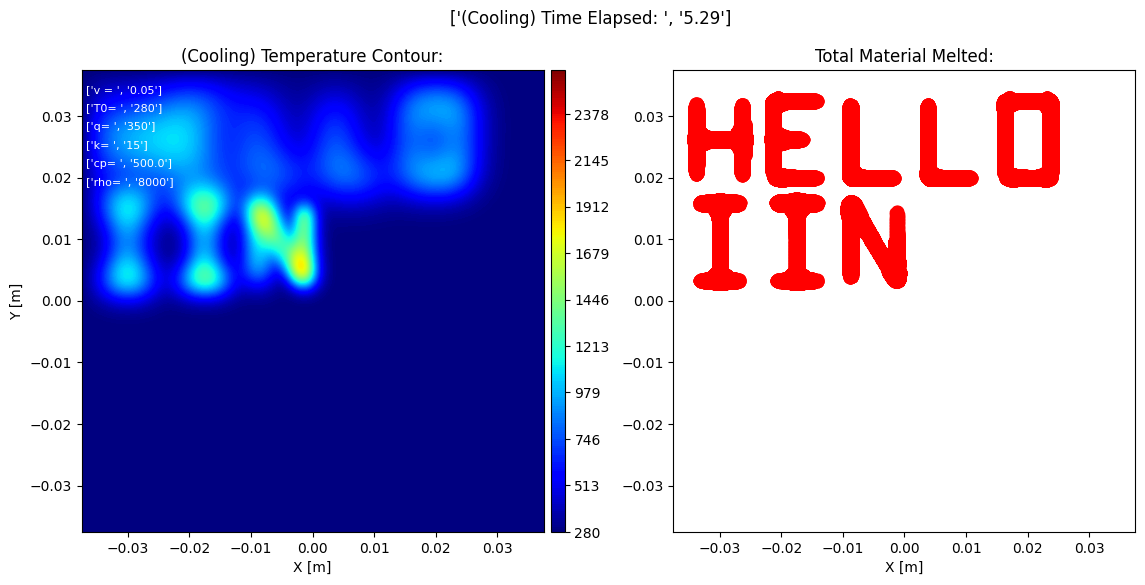

In [8]:
#Function calls
fig_Both,axc,axp,cvals = initialize_Plots(T0,q,k,cp,rho,Est_Max_Temp,Temp_Definition,x_length,y_length,Window_Pos,Scale)
hdisplay_Both = display.display("", display_id=True);
Store_X_B_final = np.array([]);
Store_Y_B_final = np.array([]);
Store_X_B = list();
Store_Y_B = list();
Store_T = list();
it = 0;
for t in range((Data_points-1)+ After_Data_points): #sets loop to calcuate and plot for each data point
  T_pre = T; # resets the previous Temp matrix
  if Save_Animation == 'Yes':    
    Store_T.append(np.copy(T))
  if t<=Data_points-1:
    X_Bounds,Y_Bounds = Melt_Bound(Melt_Temp,T,x,y,); # calculate bound points for data point t
    if Save_Animation == 'Yes': 
      Store_X_B.append(X_Bounds.copy());
      Store_Y_B.append(Y_Bounds.copy());
    if X_Bounds.size>0:
      Store_X_B_final = np.concatenate((Store_X_B_final,np.array(X_Bounds))); # store all bound points for final result
      Store_Y_B_final = np.concatenate((Store_Y_B_final,np.array(Y_Bounds)));
    if Sim_Type == 'Steps':
      if t % n == 0: #for every frame generated plot the temp contour and boundary points for data point t 
        T_Cont,Puddle = plt_Both(Time,t,axc,axp,X_Bounds,Y_Bounds,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both)
        art.Artist.remove(Puddle)
        time.sleep(.0001)
        T_Cont.remove()
      if t == Data_points-1 or t == Data_points: # makes the final data point shown independent of frame ratio n
        T_Cont,Puddle = plt_Both(Time,t,axc,axp,X_Bounds,Y_Bounds,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both)
        Puddle.remove()
        time.sleep(.0001)
        T_Cont.remove()

    T_diff = Diffusion(nx,ny,diff_coeff,T_pre,T) #calls the diffusion function for data point t

    T = Heat_Dist(nx,ny,t,alpha,rho,cp,dt,xq_pos,yq_pos,T_diff) #calls the heat distribution function for data point dt
    
  if t> Data_points: # if greater than data points, enter the cooldown phase
    if Sim_Type == 'Steps':
      if it == 0:
        axp.set_title('Total Material Melted:')
        Puddle = axp.scatter(Store_X_B_final, Store_Y_B_final,c='red'); # plot all boundary points to show total melted material
        it = 1;
    if t % n == 0:
      if Sim_Type == 'Steps':
        T_Cont = plt_Contour(Time,t,axc,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both); # plot the next temp contour
      if Save_Animation == 'Yes':
        Store_T.append(np.copy(T))
    if t == (Data_points-1)+ After_Data_points-1:
      if Sim_Type == 'Steps':      
        T_Cont = plt_Contour(Time,t,axc,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both); # plot final temp contour
        Puddle = axp.scatter(Store_X_B_final, Store_Y_B_final,c='red'); # plot all boundary points to show total melted material
      if Save_Animation == 'Yes':
          Store_T.append(np.copy(T))
        
    T_diff = Diffusion(nx,ny,diff_coeff,T_pre,T);
    if Sim_Type == 'Final':
      if t == (Data_points-1)+ After_Data_points-1:
        axp.set_title('Total Material Melted:')
        Puddle = axp.scatter(Store_X_B_final, Store_Y_B_final,c='red'); # plot all boundary points to show total melted material
        T_Cont = plt_Contour(Time,t,axc,x,y,T,cvals,fig_Both,hdisplay=hdisplay_Both); # plot final temp contour
plt.close()
if Save_Animation == 'Yes':
  print('Animation Being Saved...')
  fig_Both,(axc,axp) = plt.subplots(1,2)
  fig_Both.set_figheight(6)
  fig_Both.set_figwidth(14)
  anim = animation.FuncAnimation(fig_Both,animate_new,frames=Frames_Used,cache_frame_data = False); 
  writergif = animation.HTMLWriter(n); 
  print('Making Frames...')
  anim.save(file_name,writer=writergif);
  plt.close(fig_Both)  
  print('Animation Saved in Present Working Directory With Name - ', file_name)
  Path_Vid = display.HTML(filename=file_name);
  display.display(Path_Vid)
  plt.close()  